In [2]:
import numpy as np
import pandas as pd
import pylab as pl
%pylab inline

Populating the interactive namespace from numpy and matplotlib


#TIME SERIES ANALYSIS

#Goal: Find outliers, trends and periodicity in the MTA turnstile data
    

##DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP. You can get it in the github repo as well as here: http://cosmo.nyu.edu/~fb55/UI_CUSP_2015/data/MTA_Fare.npy. 

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


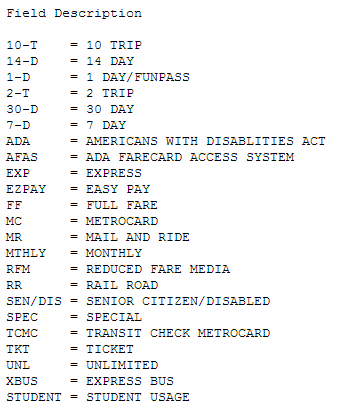

In [3]:
from IPython.display import Image
Image(filename = "Ridetypes.png")

#Task 1: 
###Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series. Identify it and figure out what it is due to.

###Reading in data

In [4]:
fare_data = np.load('MTA_Fare.npy')

print fare_data.shape

print 'stations: ', len(fare_data) # stations
print 'fare types: ', len(fare_data[0]) # fare types
print 'weeks: ', len(fare_data[0][0]) # weeks

# print fare_data

(600, 23, 194)
stations:  600
fare types:  23
weeks:  194


###Cleaning up NaN values

In [5]:
fare_data = np.where(fare_data !=-1, fare_data, np.nan)
print fare_data

[[[  5.69610000e+04   6.47030000e+04   6.80020000e+04 ...,   3.65270000e+04
     3.39290000e+04   3.68240000e+04]
  [  1.73200000e+03   2.08300000e+03   2.10700000e+03 ...,   1.26400000e+03
     1.17200000e+03   1.23800000e+03]
  [  2.03000000e+02   2.76000000e+02   2.45000000e+02 ...,   1.86000000e+02
     1.67000000e+02   1.67000000e+02]
  ..., 
  [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   0.00000000e+00]
  [             nan              nan              nan ...,   1.12100000e+03
     1.37700000e+03   7.12000000e+02]]

 [[  1.62100000e+04   2.01790000e+04   2.17690000e+04 ...,              nan
                nan              nan]
  [  5.03000000e+02   6.47000000e+02   6.65000000e+02 ...,              nan
                nan              nan]
  [  4.10000000e+01   4.30000000e+01   4.40000000e+01 ...,              nan
  

###Creating array of fare types

In [6]:
ride_types = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

print ride_types

['10t' '14d' '1d' '2t' '30d' '7d' 'ada' 'afas' 'exp' 'ez' 'ff' 'mc' 'mr'
 'month' 'rfm' 'rr' 'sen' 'spec' 'tcmc' 't' 'umlim' 'xbus' 'stud']


###Creating array of the weeks that the data spans

In [7]:
# Each time series (per station, per ticket type) contains the number of swipes per week 
# for 194 weeks from 05/21/2010 to 02/21/2014.

# ARE WE MISSING SOME WEEKS?

weeks = pd.date_range(start='05/21/2010', periods=194, freq='W-SUN')
print weeks
print len(weeks)
# type(weeks)

DatetimeIndex(['2010-05-23', '2010-05-30', '2010-06-06', '2010-06-13',
               '2010-06-20', '2010-06-27', '2010-07-04', '2010-07-11',
               '2010-07-18', '2010-07-25', 
               ...
               '2013-12-01', '2013-12-08', '2013-12-15', '2013-12-22',
               '2013-12-29', '2014-01-05', '2014-01-12', '2014-01-19',
               '2014-01-26', '2014-02-02'],
              dtype='datetime64[ns]', length=194, freq='W-SUN', tz=None)
194


###Summing up data across different dimensions for the analysis

In [8]:
# creating sum of all trips for each station in each week

stations_trips = np.nansum(fare_data, axis=1)
print stations_trips.shape
# print stations_trips

# creating sum of all trips for each fare type in each week

fares_trips = np.nansum(fare_data, axis=0)
print fares_trips.shape
# print fares_trips

# creating sum of all trips for each week

total_trips = np.nansum(fares_trips, axis=0)
print total_trips.shape
# print total_trips

(600, 194)
(23, 194)
(194,)


###Calculating thresholds for catching extreme data that is > 3 standard deviations

In [9]:
print total_trips.mean(), total_trips.std()
thresholds = [total_trips.mean() + 3*total_trips.std(), 
              total_trips.mean() - 3*total_trips.std()]
print thresholds

29781349.8711 2983960.4217
[38733231.136236683, 20829468.606031362]


###Plotting the total trip trends for each fare type with threshold lines

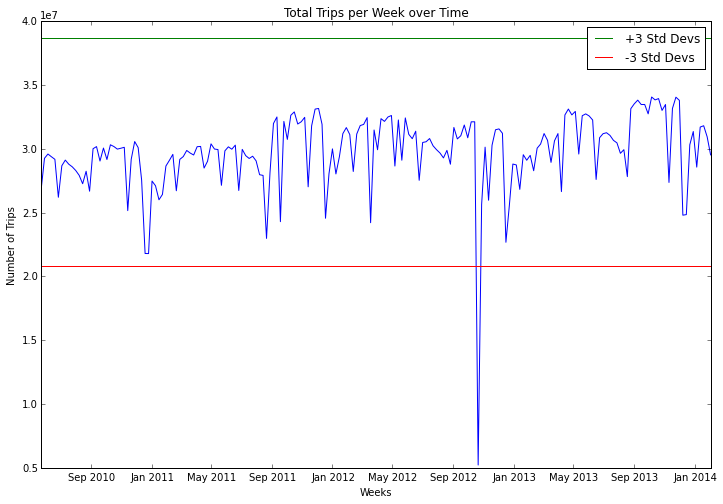

In [10]:
pl.figure(figsize=(12,8))

maxt = np.empty(194); maxt.fill(thresholds[0])
mint = np.empty(194); mint.fill(thresholds[1])

pl.title('Total Trips per Week over Time')
pl.xlabel('Weeks')
pl.ylabel('Number of Trips')
pl.plot(weeks, total_trips)
pl.plot(weeks, maxt, label='+3 Std Devs')
pl.plot(weeks, mint, label='-3 Std Devs')
pl.legend()

###The significant event which shut down the MTA was Hurricane Sandy in Nov 2012. There is an obvious drop in subway ridership across the system.

------------------
#Task 2: 
###Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)

###Calculating and plotting the rolling average (10 weeks) for each fare type over time

In [11]:
rolling = pd.rolling_mean(np.transpose(fares_trips), 10)
print rolling
print len(rolling)
print len(rolling[0])

[[             nan              nan              nan ...,              nan
               nan              nan]
 [             nan              nan              nan ...,              nan
               nan              nan]
 [             nan              nan              nan ...,              nan
               nan              nan]
 ..., 
 [  1.29185067e+07   6.92278200e+05   5.72442000e+04 ...,   5.33980000e+03
    8.49700000e+02   1.18688130e+06]
 [  1.27949711e+07   6.78913900e+05   5.63774000e+04 ...,   5.32550000e+03
    8.21100000e+02   1.16974380e+06]
 [  1.26164722e+07   6.67821700e+05   5.54549000e+04 ...,   5.36110000e+03
    7.91600000e+02   1.06853960e+06]]
194
23


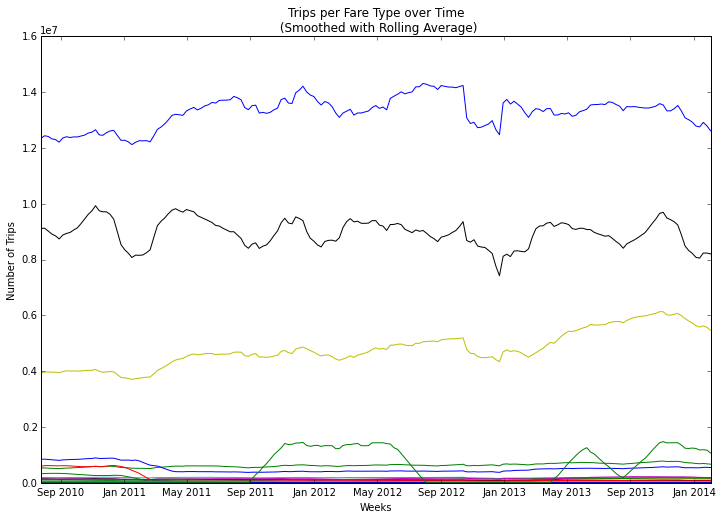

In [12]:
pl.figure(figsize=(12,8))
pl.plot(weeks,rolling)
pl.title('Trips per Fare Type over Time\n (Smoothed with Rolling Average)')
pl.xlabel('Weeks')
pl.ylabel('Number of Trips')

###Calculating the ratio of usage in last 10 weeks over the first 10 weeks



In [13]:
ratios = rolling[193,:]/rolling[9,:]
print ratios
print len(ratios)

index_growth = ratios > 1
print index_growth

[  1.02179793e+00   1.25206505e+00   1.11134514e+00   9.33803360e-01
   1.03378708e+00   1.38974760e+00   8.99841342e-01   2.09446969e-04
   1.06870327e-05   1.50195580e-06   8.18802130e-01   1.21354056e+00
   2.47849310e+04   5.78722385e-01   6.49608431e-01   2.59295989e+00
   2.90939677e+00   7.01823789e+01   1.53227106e+00   1.02158903e+00
   8.09063882e-01   1.66232675e+00              inf]
23
[ True  True  True False  True  True False False False False False  True
  True False False  True  True  True  True  True False  True  True]


###Which fare types have *grown* in popularity? I.e. which fare types have a ratio > 1?

In [14]:
print '\nFare types that have increased in popularity:'
print ride_types[index_growth]


Fare types that have increased in popularity:
['10t' '14d' '1d' '30d' '7d' 'mc' 'mr' 'rr' 'sen' 'spec' 'tcmc' 't' 'xbus'
 'stud']


###Which fare types have *decreased* in popularity? I.e. which fare types have a ratio < 1?

In [15]:
print '\nFare types that have decreased in popularity:'
print ride_types[~index_growth]


Fare types that have decreased in popularity:
['2t' 'ada' 'afas' 'exp' 'ez' 'ff' 'month' 'rfm' 'umlim']


-----------
#Task 3:
###Several stations show a prominent annual periodicity. Identify the 4 **stations** (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)

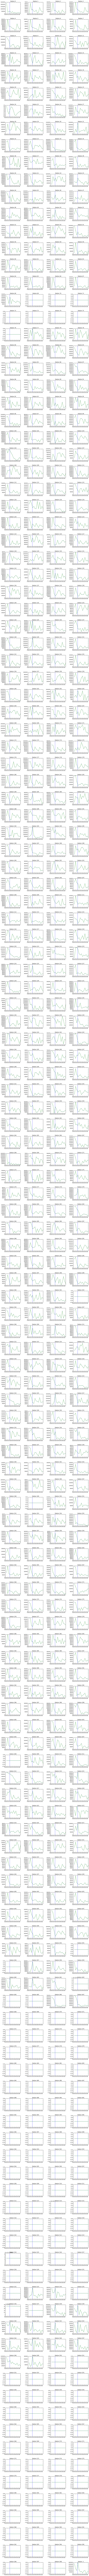

In [26]:
fig = plt.figure(figsize=(15,400))
stations_trips = pd.DataFrame(stations_trips)

for i in range(600):
    ax = fig.add_subplot(150,4,i)
    f = np.abs(np.fft.rfft(stations_trips.loc[i,:]))
    ax.plot(np.fft.rfftfreq(194, 1)[1:], (f)[1:], '.', ms = 4)
    ax.set_title("Station %i" %(i-1))
    ax.plot(np.fft.rfftfreq(194, 1)[1:], (f)[1:], '-')
    ax.set_xlim(0,1.0/15)
    pl.axvline(1.0/52)
    pl.subplots_adjust(wspace=.5, hspace=.5, left=.125, right=.9, top=1, bottom=.1)

###The five stations with the highest spike around the 1/52 vertical line have the strongest annual periodicity.

------
##Reference and Federica's notes below:

------------
#EXTRA CREDIT: Cluster. 
###Cluster the time series, i.e. identify groups of time series that look similar among each other. You can use KMeans for example to identify common trends, or PCA (Principle Component Analysis). 
###Since this is extra credit I will leave it to you to figure out the details, but for KMeans for e.g. if you use the sklearn.cluster package it would look something like:

###i am flattening the first 2 dimensions of the cube to cluster all light curves for all stations and all types

tots = data.transpose(2,0,1).reshape(data.shape[2], data.shape[1]*data.shape[0]).T

###removing empty light curves
tots = tots[tots.std(1)>0]

###with Kmeans you have to choose the number of clusters ahead km = 

KMeans(n_clusters=10)

###and standardize the lightcurves before clustering
vals = ((tots.T - tots.mean(1))/tots.std(1)).T

###then you can run:

km.fit(vals)

#HINTS: 

##When I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average)


#Possibly useful functions

##I used a variety of functions, most of them you are familiar with already. here are a few that you may not have encountered yet which I used. 
##(But you do not have to use them! there are many ways to do things and you do not have to solve this problem like I did)

* the numpy function np.where() returns the index where a condition is true. it is slow and inefficient but very intuitive and convenient


* the nupy functions np.nansum(), np.sum(), np.nanmean() etc take an array and the axis along which to sum as inputs. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...


* to find periodicity you can use fourier transforms. if you choose to use the numpy package you may want to use the real fft function:  np.fft.rfft  
     
     np.fft.rfft(mydata) 
     
     will return the fourier transform, but what you want is its absolute value: np.abs(). Then to get the x axis of your plot in frequency (1/week since the data is in weeks) you can use the function 

     np.fft.rfftfreq(N, d) 
     
     which takes as arguments N = the length of your time series (the number of datapoints) and d: the Sample spacing, or 1.0/sampling_rate (in this case, with 1/week sampling, if you want the freq in units of week that is just 1)


*  the np.array.flatten() and np.array.reshape() allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which i recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series)



In [5]:
#after reading the datacube you should see:
mta.shape


(600, 23, 194)

ride types list

In [6]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

In [9]:
#after I create a date range (for example with pd.date_range())
#in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))
#all time series, each station each ride type, look like this (pretty ugly)

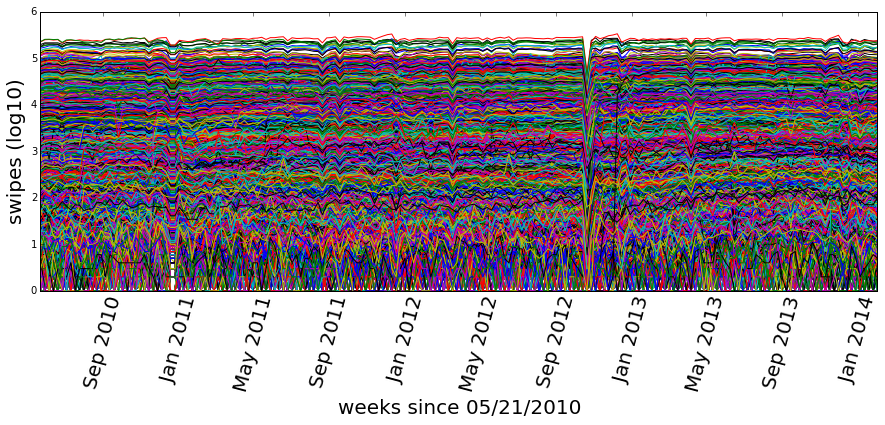

In [6]:
#as described in the instruction for some of the analysis 
#one can sum time series for all stations
print (mta.shape)
mta_allsum = np.nansum(mta, axis=0)
print (mta_allsum.shape)
#or for all ride types
mta_allsum = np.nansum(mta, axis=1)
print (mta_allsum.shape)



(600, 23, 194)
(23, 194)
(600, 194)


##NOTE ON THE TREND DETECTION:
###you should find the ride type that has the steepest increase, and the steepest decrease. notice: we are looking for something that has a more or less constant trend

###to do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per ridership type. 

###you can use a rolling mean for smoothing (pd.rolling_mean() for example), and you can calculate the ratio of the flux near the beginning to the flux near the end of the time series.

###notice that you should inspect the time series, either algorithmically or by eye, to ensure you see a trend, and not just changing structure.


###below is an example of a lightcurve with structure (top) and a lightcurve with a constant trend (bottom) both showing a large deviation between the beginning and the end of the time series

std: 153167.095823 
flux ratio beginning to end 1.53960256599
std: 33307.6081244 
flux ratio beginning to end 0.378670623705


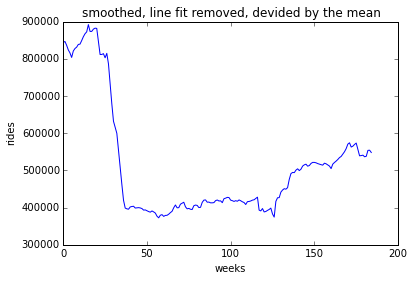

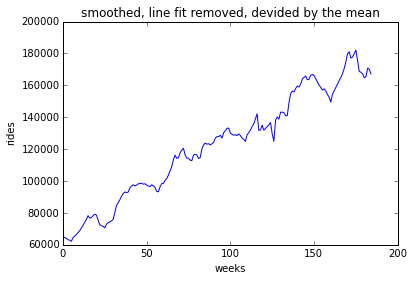

##to determine if there is a trend or strucutre you can inspect the time series visually, since there are only 23!
##an alternative, algorithmic way to do it, is to fit a line to the (smoothed) time series  and look at the residuals.

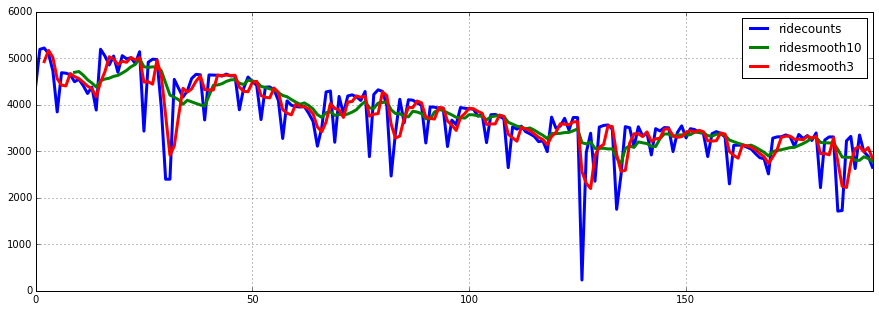

In [14]:
#here is an example of an individual time series that shows a trend, 
#after smoothing by 3 and 10 weeks

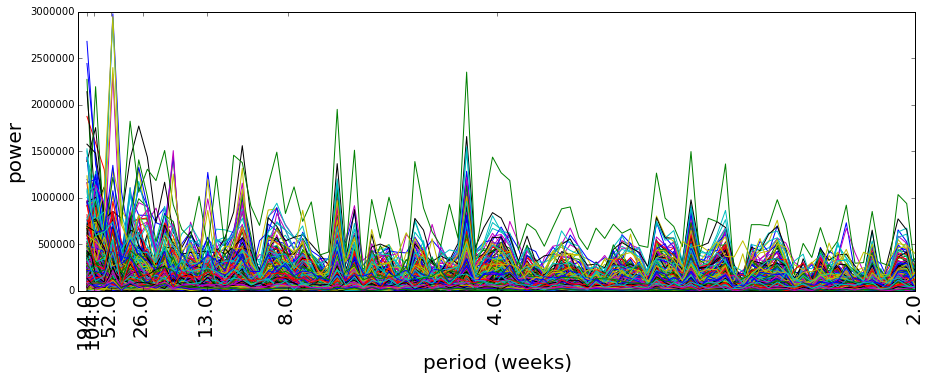

In [51]:
#this is a "power spectrum": the plot of the absolute value of the fourier transform. 
#I changed the xtick labels from frequecy (1/week) to period (in weeks)
#to facilitate the visual identification of the 1-year period peak
#(notice however that np.fft.rfftfreq(N, d)  returns frequency)

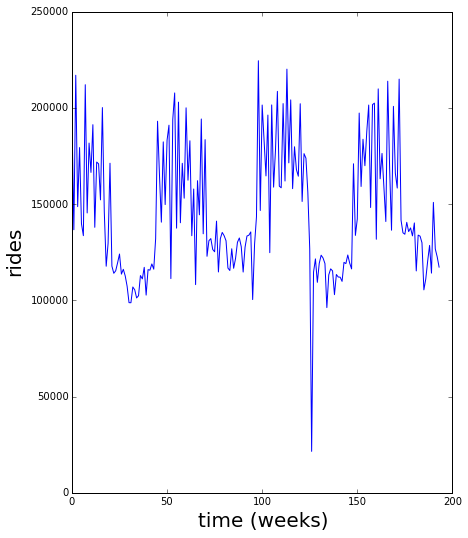

In [63]:
#and here is one of he periodic time series you should find by identifying the time series with the most power 
#at 1/52 weeks frequency in fourier space